In [1]:
# librerias

import warnings
warnings.filterwarnings('ignore')


import pylab as plt
import pandas as pd
import seaborn as sns


from keras.utils import get_file

from keras import Sequential
from keras.layers import Dense

from keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.optimizers.legacy import RMSprop

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta

# Preparación del dataset  
Las columnas tienen los siguientes significados:  
- status (Housing status - a. ready for sale or b. ready to build)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)
- price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)

In [ ]:
df_realtor = pd.read_csv('realtor-data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'realtor-data.csv'

In [ ]:
df_realtor.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [ ]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        512159 non-null  object 
 1   price         512159 non-null  float64
 2   bed           413222 non-null  float64
 3   bath          416941 non-null  float64
 4   acre_lot      407180 non-null  float64
 5   full_address  512159 non-null  object 
 6   street        511543 non-null  object 
 7   city          512100 non-null  object 
 8   state         512159 non-null  object 
 9   zip_code      511962 non-null  float64
 10  house_size    395693 non-null  float64
 11  sold_date     202507 non-null  object 
dtypes: float64(6), object(6)
memory usage: 46.9+ MB


Cambiamos la columna sold_date a formato fecha

In [ ]:
df_realtor['sold_date'] = pd.to_datetime(df_realtor['sold_date'], format='%Y-%m-%d', errors='coerce')

In [ ]:
df_realtor.sold_date.max()

Timestamp('2022-12-01 00:00:00')

En las casas no vendidas todavía, cambiamos la fecha por la fecha más reciente, puesto que es el precio al que estaba la casa  
si tenemos en cuenta la fecha más reciente

In [ ]:
df_realtor.sold_date.fillna('2022-12-01 00:00:00')

0        2022-12-01
1        2022-12-01
2        2022-12-01
3        2022-12-01
4        2022-12-01
            ...    
512154   2001-03-09
512155   1998-07-16
512156   2020-08-27
512157   2022-12-01
512158   2022-12-01
Name: sold_date, Length: 512159, dtype: datetime64[ns]

Vamos a eliminar las columnas full_address, street y city puesto que esa info es redundante con la información que nos ofrece la columna State

In [ ]:
df_realtor.drop('full_address', axis=1, inplace=True)
df_realtor.drop('street', axis=1, inplace=True)
df_realtor.drop('city', axis=1, inplace=True)
df_realtor.drop('zip_code', axis=1, inplace=True)

In [ ]:
df_realtor.nunique()

status           2
price         5004
bed             40
bath            36
acre_lot      2924
state           17
house_size    5704
sold_date     8220
dtype: int64

Vamos a observar las variables categóricas que nos quedan

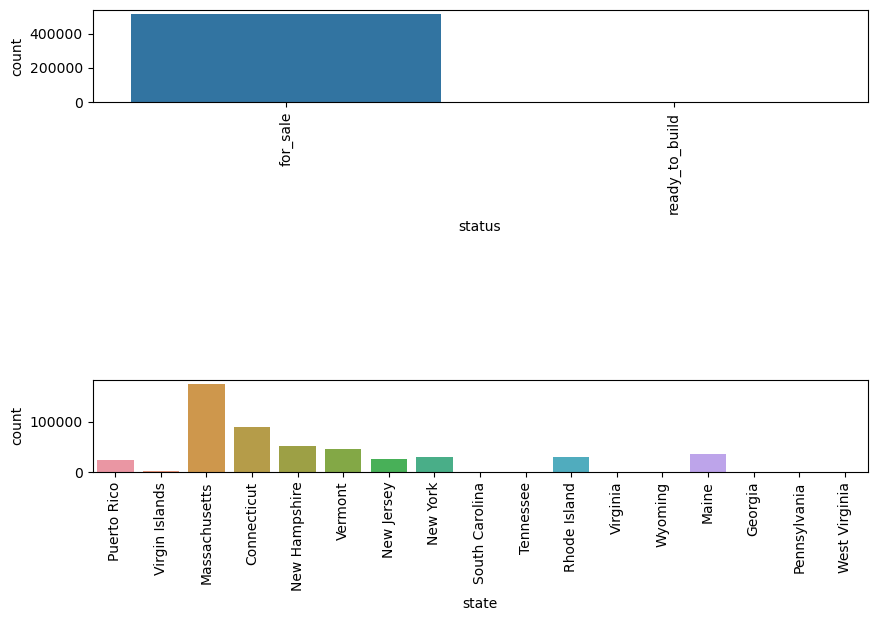

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
fig.subplots_adjust(hspace=3)

for i, col in enumerate(['status','state']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Eliminamos la variable ready_to_build, porque no hay muchas casas bajo esta categoría. Además nos interesa predecir el precio de las casas construidas

In [ ]:
df_realtor.drop('status', axis=1, inplace=True)

In [ ]:
df_realtor.state.value_counts()

Massachusetts     175248
Connecticut        89776
New Hampshire      51394
Vermont            46460
Maine              36650
New York           29990
Rhode Island       29596
New Jersey         25662
Puerto Rico        24679
Virgin Islands      2573
Georgia               48
South Carolina        25
Virginia              20
Tennessee             20
Pennsylvania          14
Wyoming                3
West Virginia          1
Name: state, dtype: int64

Puerto Rico y las Islas Vírgenes están en el Caribe. Vamos a crear un nuevo valor que sea Caribbean States

West Virginia, Tenesse, South Carolina, Virginia, Pennsylvania, Georgia y New Jersey son alunos de los estados zona Este de los Estados Unidos con menos habitantes,  
Así que los agruparemos bajo other_eastern_states

In [ ]:
def agrupacion(x):
    if x == 'Virgin Islands':
        return 'Caribbean states'
    elif x == 'Puerto Rico':
        return 'Caribbean states'
    elif x == 'West Virginia':
        return 'Other eastern states'
    elif x == 'Pennsylvania':
        return 'Other eastern states'
    elif x == 'South Carolina':
        return 'Other eastern states'
    elif x == 'Tennessee':
        return 'Other eastern states'
    elif x == 'Virginia':
        return 'Other eastern states'
    elif x == 'Georgia':
        return 'Other eastern states'
    elif x == 'New Jersey':
        return 'Other eastern states'
    else:
        return x
df_realtor['state']=df_realtor['state'].apply(agrupacion)

Como Wyoming no tiene nada que ver con el resto de los otros estados, lo borramos

In [ ]:
df_realtor = df_realtor[df_realtor['state']!='Wyoming']

In [ ]:
df_realtor.state.value_counts()

Massachusetts           175248
Connecticut              89776
New Hampshire            51394
Vermont                  46460
Maine                    36650
New York                 29990
Rhode Island             29596
Caribbean states         27252
Other eastern states     25790
Name: state, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

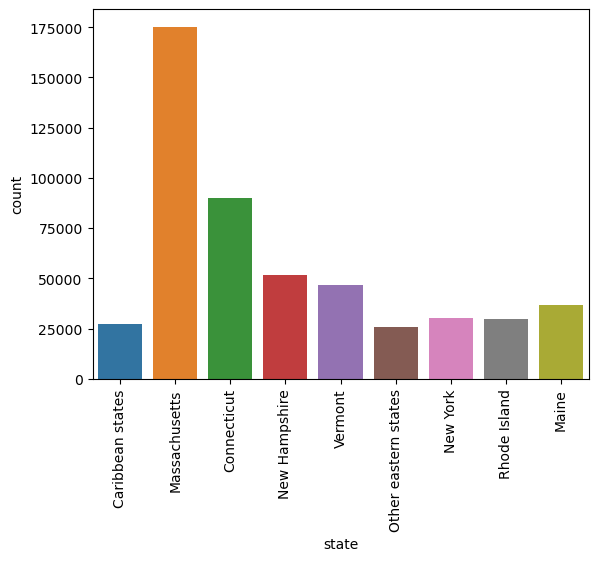

In [ ]:
fig, ax = plt.subplots()

sns.countplot(x='state', data=df_realtor, ax=ax)
plt.xticks(rotation=90)
plt.show

Creamos una nueva columna con el año de venta

In [ ]:
df_realtor

,price,bed,bath,acre_lot,state,house_size,sold_date
0,105000.0,3.0,2.0,0.12,Caribbean states,920.0,NaT
1,80000.0,4.0,2.0,0.08,Caribbean states,1527.0,NaT
2,67000.0,2.0,1.0,0.15,Caribbean states,748.0,NaT
3,145000.0,4.0,2.0,0.10,Caribbean states,1800.0,NaT
4,65000.0,6.0,2.0,0.05,Caribbean states,NaN,NaT
...,...,...,...,...,...,...,...
512154,980000.0,3.0,2.0,0.05,New York,1462.0,2001-03-09
512155,719000.0,3.0,2.0,NaN,New York,1100.0,1998-07-16
512156,679000.0,1.0,1.0,NaN,New York,NaN,2020-08-27
512157,10875000.0,20.0,22.0,NaN,New York,11335.0,NaT


In [ ]:
def anio(x):
    return x.year

In [ ]:
df_realtor['sold_year'] = df_realtor['sold_date'].apply(anio)

In [ ]:
df_realtor

,price,bed,bath,acre_lot,state,house_size,sold_date,sold_year
0,105000.0,3.0,2.0,0.12,Caribbean states,920.0,NaT,NaN
1,80000.0,4.0,2.0,0.08,Caribbean states,1527.0,NaT,NaN
2,67000.0,2.0,1.0,0.15,Caribbean states,748.0,NaT,NaN
3,145000.0,4.0,2.0,0.10,Caribbean states,1800.0,NaT,NaN
4,65000.0,6.0,2.0,0.05,Caribbean states,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...
512154,980000.0,3.0,2.0,0.05,New York,1462.0,2001-03-09,2001.0
512155,719000.0,3.0,2.0,NaN,New York,1100.0,1998-07-16,1998.0
512156,679000.0,1.0,1.0,NaN,New York,NaN,2020-08-27,2020.0
512157,10875000.0,20.0,22.0,NaN,New York,11335.0,NaT,NaN
